# PREDICTION OF THE VACCINATION RATES AMONGST PEOPLE



DrivenData Challenge:
https://www.drivendata.org/competitions/66/flu-shot-learning/

Author: Tomasz Stankowski, August 2021, Birmingham.

The challenge is to determine the likliness of people taking the flu vaccine based on the behavioral answers from the survey.
The model is aimed at helping with understanding of the key factors that contribute to the decision.

## General imports

In [53]:
import scipy as sc
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import keras 
import tensorflow

## Data imports

Data import of the prepared datased through a standard pandas function.
The use of pandas will allow for filtering of the data.

In [54]:
X = pd.read_csv('training_set_features.csv', index_col="respondent_id")
Y = pd.read_csv('training_set_labels.csv', index_col="respondent_id")

X_target = pd.read_csv('test_set_features.csv', index_col="respondent_id")


# merge train data for plotting
tot_train = pd.merge(left=X, right=Y, how='outer', on='respondent_id')

In [55]:
print (X.columns)
print (Y.columns)
# print (X_test.columns)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')
Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')


In [56]:
# print(X.head(5))

In [57]:
# X.describe()

In [58]:
X.info()

print (X.dtypes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [59]:
# Quickly identify all the numeric columns for further use

numeric_features = X.columns[X.dtypes != "object"].values
print(numeric_features)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


The categorical variables that are sequentional are treated differently, where the sequence/order of the categories is provided to the pre-processor.
This way the income/age/education of the respondents are treated with a progressive assignement of the numerical variable.

## Visualise the incomming data

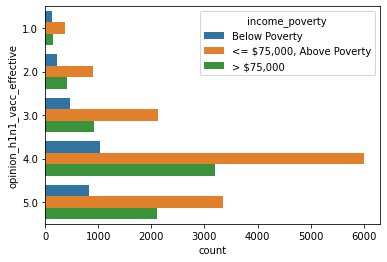

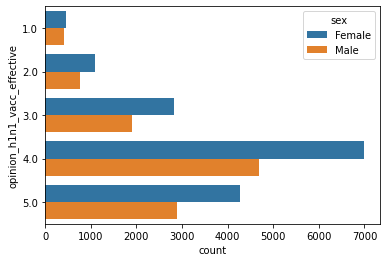

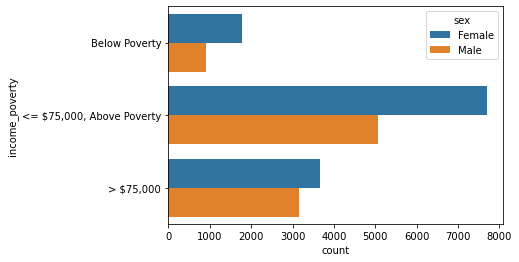

In [60]:
# bplot = sns.boxplot(y=X['opinion_h1n1_vacc_effective'], x=X['employment_industry'],
#                  width=0.5,
#                  palette="colorblind")

# bplot = sns.violinplot(x='income_poverty', y=Y['h1n1_vaccine'], hue='sex', groupby='opinion_h1n1_vacc_effective', data = X)
bplot = sns.countplot(y=X['opinion_h1n1_vacc_effective'], hue=X['income_poverty'])
plt.show()

bplot2 = sns.countplot(y=X['opinion_h1n1_vacc_effective'], hue=X['sex'])
plt.show()

bplot3 = sns.countplot(y=X['income_poverty'], hue=X['sex'])
plt.show()

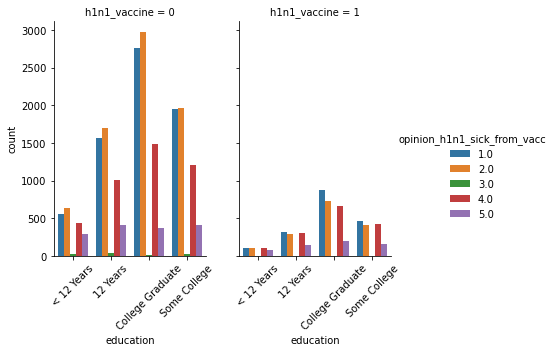

In [61]:
g = sns.catplot(x="education", hue="opinion_h1n1_sick_from_vacc", col="h1n1_vaccine",
                data=tot_train, kind="count",
                height=4, aspect=.7);
rotation = 45 
for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)

plt.show()

In [62]:
# drop all the NaNs for the initial trials

X1 = X.dropna()

print (X1.describe)

Y1 = Y[Y.index.isin(X1.index)]



<bound method NDFrame.describe of                h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
respondent_id                                                            
1                       3.0             2.0                        0.0   
7                       1.0             0.0                        0.0   
10                      2.0             1.0                        0.0   
11                      1.0             2.0                        0.0   
15                      1.0             1.0                        0.0   
...                     ...             ...                        ...   
26681                   2.0             1.0                        0.0   
26683                   1.0             2.0                        1.0   
26690                   0.0             2.0                        0.0   
26699                   2.0             2.0                        0.0   
26703                   1.0             2.0                        0.0   

   

In [63]:
# convert categorical data to dummies and ordinals
# https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79

# assign the OneHotEncoder to create dummies for categorical data. No order for variables.
ohe = preprocessing.OneHotEncoder(sparse = False)

# Example how it works on sex category:
ohe.fit_transform(X1[['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status',
                        'hhs_geo_region', 'census_msa',  'employment_industry', 'employment_occupation']])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
# Unique values in the parental level of education column

# list(X1['income_poverty'].unique())
# list(X1['age_group'].unique())
# list(X1['education'].unique())

income_categories = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']
age_group_categories = [ '18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
education_categories = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']

# # Instantiate ordinal encoder
oe = sklearn.preprocessing.OrdinalEncoder(categories = [income_categories, age_group_categories, education_categories])

# # # Apply ordinal encoder to parental level of education column

oe.fit_transform(X1[['income_poverty', 'age_group', 'education']])


array([[0., 1., 1.],
       [1., 2., 2.],
       [1., 2., 1.],
       ...,
       [1., 2., 3.],
       [1., 2., 2.],
       [1., 0., 3.]])

In [65]:
# Prepare a column transformer to link the two types of transformation for the categorical data

column_transform = make_column_transformer(
    (ohe, ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status',
            'hhs_geo_region', 'census_msa',  'employment_industry', 'employment_occupation']),
    (oe, ['income_poverty', 'age_group', 'education']),
    remainder='passthrough')

print(column_transform.fit_transform(X1))

[[0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 1. 2. 0.]
 [0. 0. 0. ... 4. 2. 0.]
 ...
 [0. 1. 0. ... 1. 2. 1.]
 [0. 0. 0. ... 4. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


## Simple SKLEARN model

In [66]:
from sklearn.model_selection import train_test_split
from sklearn import svm
y1 = Y1['h1n1_vaccine']
# Use the train-test splitter on the known dataset to train the models and check the cross-validation accuracy
X_train, X_test, Y_train, Y_test = train_test_split(X1, y1, test_size=0.4, random_state=0)

# Select a classifier
clf = svm.SVC(kernel='linear', C=10, probability=True)

clf_pipeline = make_pipeline(column_transform, clf)
clf_pipeline.fit(X_train, Y_train)
clf_predictions = clf_pipeline.predict(X_test)
preds = clf_pipeline.predict_proba(X_test)

In [67]:
# Test the predictions
mae = sklearn.metrics.mean_absolute_error(clf_predictions, Y_test)
rmse = np.sqrt(sklearn.metrics.mean_squared_error(clf_predictions, Y_test))

print('Classifier Mean Absolute Error: {:.2f}'.format(round(mae,2)))
print('Classifier Root Mean Squared Error: {:.2f}'.format(round(rmse,2)))

Classifier Mean Absolute Error: 0.16
Classifier Root Mean Squared Error: 0.40


In [68]:
# Test the predictions with ROC-AUC as this is the main metric for the competition

result1 = sklearn.metrics.roc_auc_score(Y_test, preds[:,1], average=None)

print ('ROC-AUC result for the simple model is: {:.4f}'.format(round(result1,4)))

ROC-AUC result for the simple model is: 0.8774


In [69]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {sklearn.metrics.roc_auc_score(y_true, y_score):.4f}"
    )

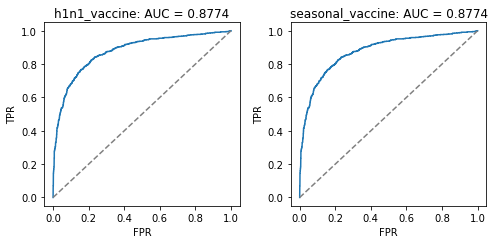

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    Y_test, 
    preds[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    Y_test, 
    preds[:, 1],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

The model has been developed from various resources in a fairly independent manner.
At this stage it has been compared with the available linear regression benchmark case:

	Benchmark: Logistic Regression	0.8185	
    https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/

The benchmark case is 0.11 better than current version of the model. Therefore it has been analysed to incorporate further elements into a new refined model.

## Refined SKLEARN model

- adding numeric processing / scaler
- refining the data imputation to be specific to type of data
- single column transformer for all data
- multioutput processing, as two variables required
- Save the output for submission


In [71]:
# Create an imputer for the missing data
from sklearn.impute import SimpleImputer

# imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# X2 = imp.fit_transform(X)

X2 = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy="most_frequent").fit_transform(X), columns = X.columns)
print(X2[:10])
print(X2.columns)

  h1n1_concern h1n1_knowledge behavioral_antiviral_meds behavioral_avoidance  \
0          1.0            0.0                       0.0                  0.0   
1          3.0            2.0                       0.0                  1.0   
2          1.0            1.0                       0.0                  1.0   
3          1.0            1.0                       0.0                  1.0   
4          2.0            1.0                       0.0                  1.0   
5          3.0            1.0                       0.0                  1.0   
6          0.0            0.0                       0.0                  0.0   
7          1.0            0.0                       0.0                  1.0   
8          0.0            2.0                       0.0                  1.0   
9          2.0            1.0                       0.0                  1.0   

  behavioral_face_mask behavioral_wash_hands behavioral_large_gatherings  \
0                  0.0                   0.

In [72]:
# new pipeline is required to use the imputer directly in the pipeline.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = sklearn.pipeline.Pipeline(steps=[
                ('standard_scaler', StandardScaler()),
                ('simple_imputer', SimpleImputer(strategy='median'))])

# ordinal processing of categorical data
income_categories = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']
age_group_categories = [ '18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
education_categories = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']

# # # Apply ordinal encoder to parental level of education column
ordinal_features = ['income_poverty', 'age_group', 'education']
oe = sklearn.preprocessing.OrdinalEncoder(categories = [income_categories, age_group_categories, education_categories])
# Instantiate ordinal encoder
ordinal_transformer = sklearn.pipeline.Pipeline(steps=[
                ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                ('ordinal_encoder', oe)])

# numeric_features = ['age', 'fare']
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# assigning dummy values to categorical data
categorical_features = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status',
                        'hhs_geo_region', 'census_msa',  'employment_industry', 'employment_occupation']

ohe = preprocessing.OneHotEncoder(sparse = False)
categorical_transformer = sklearn.pipeline.Pipeline(steps=[
                ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                ('onehot_encoder', ohe)])

preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='drop')



In [73]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.multioutput import MultiOutputClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# estimators = MultiOutputClassifier(
#             estimator=svm.SVC(kernel='linear', C=1))
#             'estimators',
estimators = MultiOutputClassifier(estimator=LogisticRegression(C=1,
                                    class_weight=None,
                                    dual=False,
                                    fit_intercept=True,
                                    intercept_scaling=1,
                                    l1_ratio=None,
                                    max_iter=100,
                                    multi_class='auto',
                                    n_jobs=None,
                                    penalty='l2',
                                    random_state=None,
                                    solver='lbfgs',
                                    tol=0.0001,
                                    verbose=0,
                                    warm_start=False))
# Adding the selector for the features. This should help to focus on the features that matter

fs = SelectKBest(score_func=f_classif, k=15)
# selector = sklearn.feature_selection.RFE(estimator, n_features_to_select=5, step=1)

In [74]:
%%time
from sklearn.model_selection import train_test_split

y2 = Y['h1n1_vaccine']

# Use the train-test splitter on the known dataset to train the models and check the cross-validation accuracy
X_train, X_test, Y_train, Y_test = train_test_split(X, y2,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=Y,
                                                    random_state=0)



Wall time: 134 ms


In [75]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
full_pipeline = sklearn.pipeline.Pipeline(steps=[('preprocessor', preprocessor),
                                        # ('select', fs.fit(X,y2)),
                                        ('classifier', svm.SVC(kernel='linear', C=1, probability=True))])
                                        
full_pipeline.fit(X_train, Y_train)
clf_predictions = full_pipeline.predict(X_test)
preds = full_pipeline.predict_proba(X_test)
# Test the predictions with ROC-AUC as this is the main metric for the competition

result2 = sklearn.metrics.roc_auc_score(Y_test, clf_predictions, average=None)

Wall time: 6min 28s


In [76]:
# Test the predictions with ROC-AUC as this is the main metric for the competition

result2 = sklearn.metrics.roc_auc_score(Y_test, preds[:, 1], average=None)

print ('ROC-AUC result for the simple model is: {:.4f}'.format(round(result2,4)))


ROC-AUC result for the simple model is: 0.8371


In [77]:
y3 = Y['seasonal_vaccine']

# Use the train-test splitter on the known dataset to train the models and check the cross-validation accuracy
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, y3,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=Y,
                                                    random_state=0)

In [78]:
full_pipeline.fit(X_train2, Y_train2)
clf_predictions2 = full_pipeline.predict(X_test2)
preds2 = full_pipeline.predict_proba(X_test2)

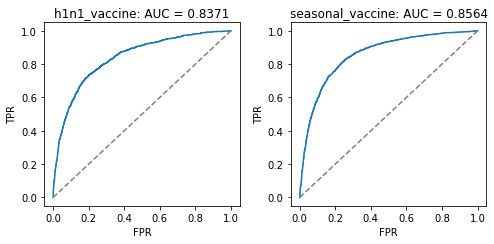

In [79]:
fig2, ax2 = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    Y_test, 
    preds[:, 1], 
    'h1n1_vaccine',
    ax=ax2[0]
)
plot_roc(
    Y_test2, 
    preds2[:, 1],
    'seasonal_vaccine',
    ax=ax2[1]
)
fig2.tight_layout()

In [80]:
# Retrain the model for the target data
y2 = Y['h1n1_vaccine']
y3 = Y['seasonal_vaccine']

full_pipeline.fit(X, y2)
res_preds = full_pipeline.predict_proba(X_target)

full_pipeline.fit(X, y3)
res_preds2 = full_pipeline.predict_proba(X_target)

In [81]:
# Read the submission format

submission_df = pd.read_csv("submission_format.csv", 
                            index_col="respondent_id")

submission_df.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [82]:
X_target.head()
len (X_target)
a = pd.DataFrame(res_preds2)
len(Y)

26707

In [83]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(X_target.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = res_preds[:, 1]
submission_df["seasonal_vaccine"] = res_preds2[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.063865,0.241847
26708,0.059470,0.038108
26709,0.345430,0.602401
26710,0.580379,0.859200
26711,0.119703,0.467553


In [84]:
submission_df.to_csv('stankowski_submission.csv', index=True)